In [72]:
# Import necessary libraries
import sys
from pathlib import Path
repo_root = Path("/home/ubuntu/michael/MSc-Machine-Learning-Project")
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
import time
import os
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product 
from mamba_ssm import Mamba
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from mamba_ssm import Mamba
from torch.utils.data import TensorDataset, DataLoader
from prob_mamba.models import FeatureNet, ProbabilisticMamba 
from prob_mamba.utils import param_count, softplus_pos, train_prob_with_history

In [2]:
# Data directory
data_dir = repo_root / "Datasets" / "Processed"

#Set seed for reproducibility
seed = 21003415
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Models to test:
1. $\text{ARIMA}(p,d,q)$, select $p,d,q$ via Bayesian Information Criterion (BIC);
2. GARCH (1,1) with leanrt mean from (1);
3. Simple RNN
4. Vanilla Mamba
5. Prob_mamba


In [12]:
# 1. ARIMA
def _clean_series(y):
    y = pd.Series(y, dtype="float64").replace([np.inf, -np.inf], np.nan).dropna()
    if len(y) < 50:
        print(f"[ARIMA] Warning: very short series ({len(y)} obs).")
    if y.std() < 1e-12:
        raise ValueError("[ARIMA] Series is (near) constant after cleaning.")
    return y

def arima_select_bic(y_train, p_max=3, q_max=3, d_candidates=(0,), trend='n'):
    """
    Returns (order, fitted_model) with order chosen by BIC.
    Uses a small grid and relaxed constraints for stability on returns.
    """
    y = _clean_series(y_train)
    best = None
    best_fit = None
    for d in d_candidates:
        for p in range(p_max + 1):
            for q in range(p_max + 1):
                if (p, d, q) == (0, 0, 0):
                    continue
                try:
                    fit = (ARIMA(y, order=(p, d, q),
                                 trend=trend,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
                           .fit())  # no disp / method kwargs
                    bic = fit.bic
                    if (best is None) or (bic < best[0]):
                        best = (bic, (p, d, q))
                        best_fit = fit
                except Exception:
                    continue
    if best is None:
        # Fallback to AR(1)
        fit = (ARIMA(y, order=(1, 0, 0),
                     trend=trend,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
               .fit())
        print("[ARIMA] Grid failed; falling back to AR(1).")
        return (1, 0, 0), fit
    return best[1], best_fit

def arima_fit_forecast(train_df, val_df, test_df, target_col='y_next',
                       p_max=3, q_max=3, d_candidates=(0,), trend='n',
                       return_fit: bool = False):
    y_tr  = _clean_series(train_df[target_col].values)
    y_val = _clean_series(val_df[target_col].values)
    y_te  = _clean_series(test_df[target_col].values)

    order, _ = arima_select_bic(y_tr, p_max=p_max, q_max=q_max,
                                d_candidates=d_candidates, trend=trend)
    print(f"[ARIMA] Selected (p,d,q) by BIC: {order}")

    # Refit on train+val and forecast length of test
    y_trval = pd.concat([pd.Series(y_tr), pd.Series(y_val)], axis=0).reset_index(drop=True)
    final = (ARIMA(y_trval, order=order,
                   trend=trend,
                   enforce_stationarity=False,
                   enforce_invertibility=False)
             .fit())
    fc = final.forecast(steps=len(y_te))
    rmse = float(np.sqrt(np.mean((fc.values - y_te.values)**2)))

    if return_fit:
        return order, rmse, fc, final
    return order, rmse, fc

/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ARIMA] Selected (p,d,q) by BIC: (1, 0, 0)
[ARIMA] order=(1, 0, 0), test RMSE on NYSE dataset=0.011142
Residual mean/std: 0.0003130936956438713 0.010943193390615493


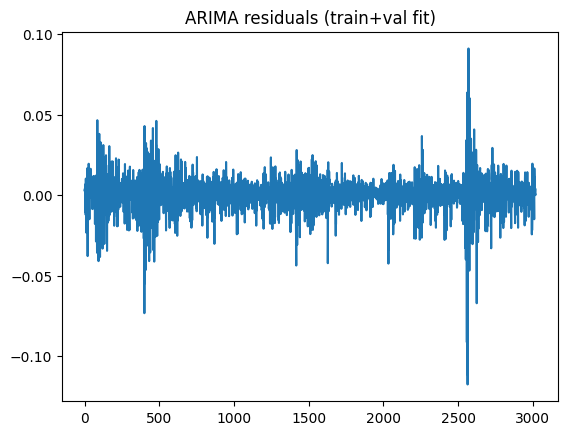

In [15]:
# ARIMA on NYSE data
train_df = feather.read_feather(data_dir / "cleaned_NYSE_train.arrow")
val_df   = feather.read_feather(data_dir / "cleaned_NYSE_val.arrow")
test_df  = feather.read_feather(data_dir / "cleaned_NYSE_test.arrow")

order, rmse, fc, fit_res = arima_fit_forecast(train_df, val_df, test_df, return_fit=True)
print(f"[ARIMA] order={order}, test RMSE on NYSE dataset={rmse:.6f}")
print("Residual mean/std:", resid.mean(), resid.std())
plt.plot(resid); plt.title("ARIMA residuals (train+val fit)"); plt.show()

/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ARIMA] Selected (p,d,q) by BIC: (1, 0, 0)
[ARIMA] order=(1, 0, 0), test RMSE on IXIC dataset=0.015694
Residual mean/std: 0.0003130936956438713 0.010943193390615493


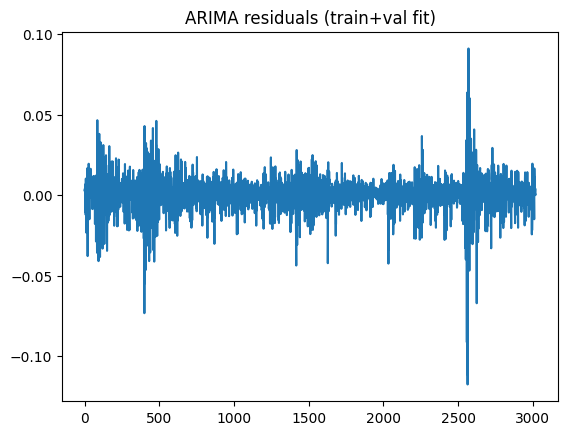

In [16]:
# ARIMA on IXIC data
train_df = feather.read_feather(data_dir / "cleaned_IXIC_train.arrow")
val_df   = feather.read_feather(data_dir / "cleaned_IXIC_val.arrow")
test_df  = feather.read_feather(data_dir / "cleaned_IXIC_test.arrow")

order, rmse, fc, fit_res = arima_fit_forecast(train_df, val_df, test_df, return_fit=True)
print(f"[ARIMA] order={order}, test RMSE on IXIC dataset={rmse:.6f}")
print("Residual mean/std:", resid.mean(), resid.std())
plt.plot(resid); plt.title("ARIMA residuals (train+val fit)"); plt.show()

/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ARIMA] Selected (p,d,q) by BIC: (1, 0, 0)


/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ARIMA] order=(1, 0, 0), test RMSE on Bitcoin dataset=0.005974
Residual mean/std: 0.0003130936956438713 0.010943193390615493


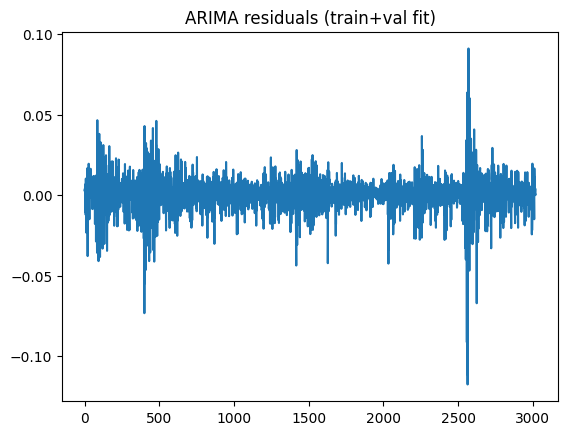

In [17]:
# ARIMA on Bitcoin data
train_df = feather.read_feather(data_dir / "cleaned_Bitcoin_train.arrow")
val_df   = feather.read_feather(data_dir / "cleaned_Bitcoin_val.arrow")
test_df  = feather.read_feather(data_dir / "cleaned_Bitcoin_test.arrow")

order, rmse, fc, fit_res = arima_fit_forecast(train_df, val_df, test_df, return_fit=True)
print(f"[ARIMA] order={order}, test RMSE on Bitcoin dataset={rmse:.6f}")
print("Residual mean/std:", resid.mean(), resid.std())
plt.plot(resid); plt.title("ARIMA residuals (train+val fit)"); plt.show()

In [18]:
# 2. GARCH(1,1) with AR(1) mean
    
def qlike_metric(residuals: np.ndarray, var_forecast: np.ndarray) -> float:
    var = np.clip(var_forecast, 1e-12, None)
    return float(np.mean((residuals**2) / var + np.log(var)))

def garch_fit_forecast_ar1(train_df, val_df, test_df, target_col='y_next', dist='normal'):
    """
    Fit AR(1)-GARCH(1,1) on train+val and forecast test horizon.
    Returns RMSE, QLIKE, mean forecasts, variance forecasts.
    """
    # series (keep pandas index just for sanity; not required)
    y_tr  = pd.Series(train_df[target_col].values).dropna()
    y_val = pd.Series(val_df[target_col].values).dropna()
    y_te  = pd.Series(test_df[target_col].values).dropna()

    y_trval = pd.concat([y_tr, y_val], axis=0)

    # AR(1) mean + GARCH(1,1) variance
    am = arch_model(
        y_trval,
        mean='ARX', lags=1,  # <-- AR(1) mean
        vol='GARCH', p=1, q=1,
        dist=dist
    )
    res = am.fit(disp='off')

    # Dynamic out-of-sample forecast for the test horizon
    h = len(y_te)
    fc = res.forecast(horizon=h, reindex=False)
    mu_hat  = fc.mean.values[-1, :]      # shape (h,)
    var_hat = fc.variance.values[-1, :]  # shape (h,)

    rmse  = float(np.sqrt(np.mean((mu_hat - y_te.values)**2)))
    qlike = qlike_metric(y_te.values - mu_hat, var_hat)
    return rmse, qlike, mu_hat, var_hat

In [19]:
train_df = feather.read_feather(data_dir / "cleaned_NYSE_train.arrow")
val_df   = feather.read_feather(data_dir / "cleaned_NYSE_val.arrow")
test_df  = feather.read_feather(data_dir / "cleaned_NYSE_test.arrow")
garch_rmse, garch_qlike, mu_hat, var_hat = garch_fit_forecast_ar1(train_df, val_df, test_df)
print(f"[GARCH(1,1)] Test RMSE on NYSE data : {garch_rmse:.6f} | QLIKE: {garch_qlike:.6f}")

[GARCH(1,1)] Test RMSE on NYSE data : 0.011244 | QLIKE: -7.937587


/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [20]:
train_df = feather.read_feather(data_dir / "cleaned_IXIC_train.arrow")
val_df   = feather.read_feather(data_dir / "cleaned_IXIC_val.arrow")
test_df  = feather.read_feather(data_dir / "cleaned_IXIC_test.arrow")
garch_rmse, garch_qlike, mu_hat, var_hat = garch_fit_forecast_ar1(train_df, val_df, test_df)
print(f"[GARCH(1,1)] Test RMSE on IXIC data : {garch_rmse:.6f} | QLIKE: {garch_qlike:.6f}")

[GARCH(1,1)] Test RMSE on IXIC data : 0.015729 | QLIKE: -7.175174


/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000149. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [21]:
train_df = feather.read_feather(data_dir / "cleaned_Bitcoin_train.arrow")
val_df   = feather.read_feather(data_dir / "cleaned_Bitcoin_val.arrow")
test_df  = feather.read_feather(data_dir / "cleaned_Bitcoin_test.arrow")
garch_rmse, garch_qlike, mu_hat, var_hat = garch_fit_forecast_ar1(train_df, val_df, test_df)
print(f"[GARCH(1,1)] Test RMSE on Bitcoin data : {garch_rmse:.6f} | QLIKE: {garch_qlike:.6f}")

[GARCH(1,1)] Test RMSE on Bitcoin data : 0.005976 | QLIKE: -9.174212


/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.534e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/ubuntu/ucl_msc-dissertation_2025_michael-yiu-2/prob_mamba/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [32]:
# Alternative: Scale the series by 100 when fitting, then unscale the forecasts
def qlike_metric(residuals: np.ndarray, var_forecast: np.ndarray) -> float:
    var = np.clip(var_forecast, 1e-12, None)
    return float(np.mean((residuals**2) / var + np.log(var)))

def garch_fit_forecast_ar1(train_df, val_df, test_df, target_col='y_next',
                           dist='normal', scale=100.0):
    """
    Fit AR(1)-GARCH(1,1) on train+val using scaled returns (×scale),
    then unscale mean/variance forecasts back to original units.
    """
    # 1) Pull series
    y_tr  = pd.Series(train_df[target_col].values).dropna()
    y_val = pd.Series(val_df[target_col].values).dropna()
    y_te  = pd.Series(test_df[target_col].values).dropna()

    # 2) Fit on train+val (scaled)
    y_trval = pd.concat([y_tr, y_val], axis=0)
    y_trval_s = y_trval * scale
    am = arch_model(y_trval_s, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist=dist)
    res = am.fit(disp="off")

    # 3) Forecast test horizon (still scaled)
    fc = res.forecast(horizon=len(y_te), reindex=False)
    mu_hat_s  = fc.mean.values[-1, :]       # scaled mean forecast (len(test),)
    var_hat_s = fc.variance.values[-1, :]   # scaled variance forecast

    # 4) Unscale back to original units
    mu_hat  = mu_hat_s / scale
    var_hat = var_hat_s / (scale**2)

    # 5) Metrics in original units
    rmse  = float(np.sqrt(np.mean((mu_hat - y_te.values)**2)))
    qlike = qlike_metric(y_te.values - mu_hat, var_hat)
    return rmse, qlike, mu_hat, var_hat

In [33]:
train_df = feather.read_feather(data_dir / "cleaned_NYSE_train.arrow")
val_df   = feather.read_feather(data_dir / "cleaned_NYSE_val.arrow")
test_df  = feather.read_feather(data_dir / "cleaned_NYSE_test.arrow")
garch_rmse, garch_qlike, mu_hat, var_hat = garch_fit_forecast_ar1(train_df, val_df, test_df)
print(f"[GARCH(1,1)] Test RMSE: {garch_rmse:.6f} | QLIKE: {garch_qlike:.6f}")

[GARCH(1,1)] Test RMSE: 0.011170 | QLIKE: -7.978957


In [34]:
train_df = feather.read_feather(data_dir / "cleaned_IXIC_train.arrow")
val_df   = feather.read_feather(data_dir / "cleaned_IXIC_val.arrow")
test_df  = feather.read_feather(data_dir / "cleaned_IXIC_test.arrow")
garch_rmse, garch_qlike, mu_hat, var_hat = garch_fit_forecast_ar1(train_df, val_df, test_df)
print(f"[GARCH(1,1)] Test RMSE: {garch_rmse:.6f} | QLIKE: {garch_qlike:.6f}")

[GARCH(1,1)] Test RMSE: 0.015731 | QLIKE: -7.105499


In [35]:
train_df = feather.read_feather(data_dir / "cleaned_Bitcoin_train.arrow")
val_df   = feather.read_feather(data_dir / "cleaned_Bitcoin_val.arrow")
test_df  = feather.read_feather(data_dir / "cleaned_Bitcoin_test.arrow")
garch_rmse, garch_qlike, mu_hat, var_hat = garch_fit_forecast_ar1(train_df, val_df, test_df)
print(f"[GARCH(1,1)] Test RMSE: {garch_rmse:.6f} | QLIKE: {garch_qlike:.6f}")

[GARCH(1,1)] Test RMSE: 0.005974 | QLIKE: -8.977959


In [3]:
# Function to convert time-series data into input sequences
def create_sequences(data: pd.DataFrame, sequence_length: int, feature_columns: list, target_column: str):
    """
    Converts a time-series DataFrame into input sequences and corresponding target values.
    Args:
        data (pd.DataFrame): The pre-processed input DataFrame;
        sequence_length (int): The number of time steps in each input sequence;
        feature_columns (list): The list of the column names to be used as inout features;
        target_column (str): The name of the column to be predicted.
    Returns:
        tuple: A tuple containing the input sequences (X) and corresponding target values (y) as numpy arrays.
    """
    if target_column in feature_columns:
        raise ValueError("target_column should not be in feature_columns")
    
    # Define the features and target values
    features = data[feature_columns].values
    targets = data[target_column].values

    # Initialize lists to hold sequences and targets
    X, y = [], []
    N = len(data)
    L = sequence_length
    if N < L:
        raise ValueError(f"Data length {N} is shorter than sequence length {L}.")

    # Loop through the data to create sequences
    for i in range(0, N - L + 1):
        # The sequence of features
        seq_x = features[i:i + L]
        # The target value at the end of the sequence 
        seq_y = targets[i + L - 1]
        X.append(seq_x)
        y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    return X, y


In [4]:
if __name__ == "__main__":
    # Configuation
    sequence_length_map = {
        "cleaned_Bitcoin": 720,
        "cleaned_IXIC": 270,
        "cleaned_NYSE": 270
    }
    target_column = 'y_next' # next-period log return
    # Data to process
    Arrow_files_prefix= [
        'cleaned_IXIC',
        'cleaned_NYSE',
        'cleaned_Bitcoin'
    ]
    # Initialise a dictionary to hold all the final data
    all_processed_data = {}

    for prefix in Arrow_files_prefix:
        print(f"\n Creating Sequences for {prefix}:")

        # Step 1:  Load original data to calculate log returns
        original_path = f"/home/ubuntu/michael/MSc-Machine-Learning-Project/Datasets/Processed/{prefix}.arrow"
        original_df = feather.read_feather(original_path)
        date_col = "timestamp" if "timestamp" in original_df.columns else "Date"
        original_df[date_col] = pd.to_datetime(original_df[date_col])
        original_df = original_df.sort_values(date_col).reset_index(drop=True)
        price_col = "Price" if "Price" in original_df.columns else "BTC_USDT_1h_close"
        if price_col not in original_df.columns:
            raise ValueError("Expected column 'Price' or 'BTC_USDT_1h_close' in dataframe.")
        # sanity: no non-positive prices
        if (original_df[price_col] <= 0).any():
            raise ValueError(f"Non-positive prices found in {price_col} — clean data first.")
        #Compute log_price, log_returns
        original_df["_log_price"] = np.log(original_df[price_col])
        original_df["ret_t"] = original_df["_log_price"].diff() # today's log return
        original_df["y_next"] = original_df["_log_price"].shift(-1) - original_df["_log_price"] # next period log return
        original_df = original_df.dropna(subset=["y_next"]).reset_index(drop=True)
        print("Computed log_price, ret_t and y_next inb original data.")

        # Step 2: Load the pre-processed data
        train_df = feather.read_feather(f'{data_dir}/{prefix}_train.arrow')
        val_df = feather.read_feather(f'{data_dir}/{prefix}_val.arrow')
        test_df = feather.read_feather(f'{data_dir}/{prefix}_test.arrow')
        for df in [train_df, val_df, test_df]:
            df[date_col] = pd.to_datetime(df[date_col])
        print("Loaded pre-processed taining, validation, and test data")

        # Step 3: Define features to prevent data leakage
        columns_to_drop = ['Date', 'Name', price_col, '_log_price', "y_next"]
        feature_columns = [col for col in train_df.columns if col not in columns_to_drop and col != date_col]
        print(f"Using {len(feature_columns)} input features.")

        # Step 4: Set sequence length
        default_sequence_length = 270
        short_prefix = prefix.replace("cleaned_", "")
        seq_len = sequence_length_map.get(prefix, sequence_length_map.get(short_prefix, default_sequence_length))

        # Step 5: Create windowed sequence 
        X_train, y_train = create_sequences (train_df, seq_len, feature_columns, target_column)
        X_val, y_val = create_sequences(val_df, seq_len, feature_columns, target_column)
        X_test, y_test = create_sequences(test_df, seq_len, feature_columns, target_column)

        # Diagnostic prints
        print(f"---Shapes for {prefix}---")
        print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
        print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")    

        dataset_name = prefix.split('_')[-1]
        all_processed_data[dataset_name] = {
            'X_train': X_train,
            'y_train': y_train,
            'X_val': X_val,
            'y_val': y_val,
            'X_test': X_test,
            'y_test': y_test
        }
        print("\nAll datasets processed.")


 Creating Sequences for cleaned_IXIC:
Computed log_price, ret_t and y_next inb original data.
Loaded pre-processed taining, validation, and test data
Using 60 input features.
---Shapes for cleaned_IXIC---
X_train: (2148, 270, 60), y_train: (2148,)
X_val: (215, 270, 60), y_val: (215,)
X_test: (298, 270, 60), y_test: (298,)

All datasets processed.

 Creating Sequences for cleaned_NYSE:
Computed log_price, ret_t and y_next inb original data.
Loaded pre-processed taining, validation, and test data
Using 61 input features.
---Shapes for cleaned_NYSE---
X_train: (2246, 270, 61), y_train: (2246,)
X_val: (236, 270, 61), y_val: (236,)
X_test: (179, 270, 61), y_test: (179,)

All datasets processed.

 Creating Sequences for cleaned_Bitcoin:
Computed log_price, ret_t and y_next inb original data.
Loaded pre-processed taining, validation, and test data
Using 18 input features.
---Shapes for cleaned_Bitcoin---
X_train: (11545, 720, 18), y_train: (11545,)
X_val: (1945, 720, 18), y_val: (1945,)
X_te

In [ ]:
# 3. A simple RNN
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True)  # tanh activation
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim, device=x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

def rnn_param_count(I, H, L, O):
    # (2L-1)H^2 + (I + 2L + O)H + O
    return (2*L - 1)*H*H + (I + 2*L + O)*H + O

def build_rnn(input_dim, output_dim=1, n_layers=1, target=100_000):
    a = 2*n_layers - 1
    b = input_dim + 2*n_layers + output_dim
    c = output_dim - target
    disc = b*b - 4*a*c
    H = max(1, int((-b + np.sqrt(disc)) / (2*a)))
    # small nudge for even closer match
    bestH, bestP = H, rnn_param_count(input_dim, H, n_layers, output_dim)
    for cand in [H-2, H-1, H+1, H+2]:
        if cand >= 1:
            p = rnn_param_count(input_dim, cand, n_layers, output_dim)
            if abs(p - target) < abs(bestP - target):
                bestH, bestP = cand, p
    model = SimpleRNN(input_dim, bestH, n_layers, output_dim)
    print(f"[RNN] L={n_layers}, H={bestH}, params={bestP:,}")
    return model
    


In [ ]:
# 4. Mamba
try:
    from mamba_ssm import Mamba
except Exception as e:
    raise ImportError(
        "Official mamba-ssm is required for the Vanilla Mamba baseline.\n"
        "Install it first, e.g.:\n"
        "  pip install mamba-ssm\n"
        "and ensure a compatible PyTorch/CUDA is installed."
    ) from e


class MambaModel(nn.Module):
    """
    Input proj: (input_dim -> d_model)
    n_layers of Mamba blocks (residual)
    Head: (d_model -> output_dim)
    """
    def __init__(self, input_dim, d_model=128, d_state=16, d_conv=4, expand=2,
                 output_dim=1, n_layers=1):
        super().__init__()
        self.in_proj = nn.Linear(input_dim, d_model, bias=True)
        self.blocks = nn.ModuleList([
            Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.in_proj(x)              # (B, L, d_model)
        for blk in self.blocks:
            h = h + blk(h)               # residual stack
        h = self.norm(h)
        h_last = h[:, -1, :]             # last-step regression
        return self.fc(h_last)           # (B, 1)


def build_mamba(input_dim, output_dim=1, target=100_000,
                n_layers=1, d_state=16, d_conv=4, expand=2,
                d_model_min=32, d_model_max=512, step=8, verbose=True):
    """
    Sweep d_model to match a parameter budget for the vanilla Mamba baseline.
    Requires official mamba-ssm.
    """
    # sanity: confirm Mamba is available (in case this function is reused elsewhere)
    if "Mamba" not in globals():
        raise ImportError("mamba-ssm.Mamba not found; ensure you've imported it successfully.")

    best = None
    for d_model in range(d_model_min, d_model_max + 1, step):
        m = MambaModel(input_dim, d_model=d_model, output_dim=output_dim,
                       n_layers=n_layers, d_state=d_state, d_conv=d_conv, expand=expand)
        p = param_count(m)
        if best is None or abs(p - target) < abs(best[1] - target):
            best = (m, p, d_model)
        # early stop if within 2% of target
        if abs(p - target) <= 0.02 * max(1, target):
            break

    m, p, d_model = best
    if verbose:
        print(f"[Mamba-mamba-ssm] d_model={d_model}, n_layers={n_layers}, "
              f"d_state={d_state}, params={p:,} (target≈{target:,})")
    return m


In [5]:
# Training function
def train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs):
    """
    The main training loop for a PyTorch model.

    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        loss_function (nn.Module): The loss function (e.g., nn.MSELoss).
        optimizer (torch.optim.Optimizer): The optimizer (e.g., Adam).
        num_epochs (int): The total number of epochs to train for.
        device (torch.device): The device (CPU or CUDA) to train on.
    """
    # Start the timer
    start_time = time.time()
    
    # Loop over the number of specified epochs
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # Set the model to training mode
        train_loss = 0.0
        for inputs, targets in train_loader:
            # Move data to the specified device (e.g., GPU)
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 1. Clear previous gradients
            optimizer.zero_grad()
            
            # 2. Forward pass: compute predicted outputs
            outputs = model(inputs)
            
            # 3. Calculate loss
            loss = loss_function(outputs, targets)
            
            # 4. Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # 5. Call step() to update the weights
            optimizer.step()
            
            # Accumulate the training loss
            train_loss += loss.item() * inputs.size(0)
        
        # --- Validation Phase ---
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in val_loader:
                # Move data to the specified device
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                
                # Accumulate the validation loss
                val_loss += loss.item() * inputs.size(0)
        
        # Calculate average losses for the epoch
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        
        # Print training progress (e.g., every 10 epochs)
        if (epoch + 1) % 10 == 0 or epoch == 0:
             print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
    
    # Print total training time
    end_time = time.time()
    print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")

In [6]:
# Evaluation function
def evaluation_function(model, test_loader, loss_function):
    """
    Evaluates the model on the test set and returns the average loss.
    Args:
        model (nn.Module): The trained model to evaluate.
        test_loader (DataLoader): DataLoader for the test set.
        loss_function (nn.Module): Loss function to use for evaluation.
    Returns:
        float: Final average loss on the test set.
    """
    model.to(device)  # Ensure model is on the correct device
    model.eval()  # Set model to evaluation mode
    # Initialisation
    total_loss = 0.0
    all_preds = []
    all_targets = []
    print("Evaluating model on test set...")
    start_time = time.time()
    with torch.no_grad():  # Disable gradient calculation for inference
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs) # Get model predictions
            loss = loss_function(outputs, targets) # Calculate loss
            total_loss += loss.item() * inputs.size(0)  # Accumulate loss

            # Store predictions and targets to analyse later if needed
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
        
    end_time = time.time()
    print(f"Evaluation completed in {end_time - start_time:.2f} seconds.")

    # Calculate final average loss
    final_loss = total_loss / len(test_loader.dataset)
    print(f"Final Average Loss: {final_loss:.6f}")
    return final_loss

In [7]:
# Unified training pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", "GPU" if device.type == "cuda" else "CPU")

BATCH_SIZE   = 64
OUTPUT_DIM   = 1
NUM_EPOCHS   = 100
LEARNING_RATE = 1e-3
budgets = [100_000, 300_000, 1_000_000]

from torch.utils.data import TensorDataset, DataLoader

def make_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch=BATCH_SIZE):
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                      torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)),
        batch_size=batch, shuffle=True)
    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                      torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)),
        batch_size=batch, shuffle=False)
    test_loader = DataLoader(
        TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                      torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)),
        batch_size=batch, shuffle=False)
    return train_loader, val_loader, test_loader

def build_baselines(input_dim, output_dim=OUTPUT_DIM, budgets=budgets):
    models = {}
    for T in budgets:
        models[f"rnn_{T//1000}k"] = build_rnn(input_dim, output_dim=output_dim, n_layers=1, target=T)
    for T in budgets:
        models[f"mamba_{T//1000}k"] = build_mamba(
            input_dim, output_dim=output_dim, target=T,
            n_layers=1, d_state=16, d_conv=4, expand=2,
            d_model_min=64, d_model_max=512, step=8, verbose=True
        )
    return models

def run_experiment_block(dataset_name, all_processed_data):
    X_train = all_processed_data[dataset_name]['X_train']
    y_train = all_processed_data[dataset_name]['y_train']
    X_val   = all_processed_data[dataset_name]['X_val']
    y_val   = all_processed_data[dataset_name]['y_val']
    X_test  = all_processed_data[dataset_name]['X_test']
    y_test  = all_processed_data[dataset_name]['y_test']

    INPUT_DIM = X_train.shape[2]

    train_loader, val_loader, test_loader = make_loaders(X_train, y_train, X_val, y_val, X_test, y_test)
    models_to_train = build_baselines(INPUT_DIM)

    loss_function = nn.MSELoss()
    final_results = {}

    for name, model in models_to_train.items():
        print(f"\n{'='*25} {dataset_name} — {name} {'='*25}")
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        t0 = time.time()
        train_model(model, train_loader, val_loader, loss_function, optimizer, NUM_EPOCHS)
        t1 = time.time()
        test_loss = evaluation_function(model, test_loader, loss_function)
        final_results[name] = {
            'parameters': param_count(model),
            'training_time_sec': t1 - t0,
            'test_rmse': float(np.sqrt(test_loss)),
        }
    df = pd.DataFrame(final_results).T[['parameters','training_time_sec','test_rmse']]
    print("\n--- Final Results Summary:", dataset_name, "---")
    print(df.to_string(formatters={
        'parameters': '{:,.0f}'.format,
        'training_time_sec': '{:.2f}'.format,
        'test_rmse': '{:.6f}'.format
    }))
    return df

Using GPU


In [31]:
nyse_results = run_experiment_block('NYSE', all_processed_data)
ixic_results = run_experiment_block('IXIC', all_processed_data)
btc_results  = run_experiment_block('Bitcoin', all_processed_data)

[RNN] L=1, H=286, params=100,101
[RNN] L=1, H=517, params=300,378
[RNN] L=1, H=969, params=1,000,978
[Mamba-mamba-ssm] d_model=112, n_layers=1, d_state=16, params=98,001 (target≈100,000)
[Mamba-mamba-ssm] d_model=208, n_layers=1, d_state=16, params=306,801 (target≈300,000)
[Mamba-mamba-ssm] d_model=384, n_layers=1, d_state=16, params=988,801 (target≈1,000,000)

========================= NYSE — rnn_100k =========================
Epoch 1/100 | Train Loss: 0.008363 | Val Loss: 0.003533
Epoch 10/100 | Train Loss: 0.000199 | Val Loss: 0.000243
Epoch 20/100 | Train Loss: 0.000113 | Val Loss: 0.000127
Epoch 30/100 | Train Loss: 0.000023 | Val Loss: 0.000063
Epoch 40/100 | Train Loss: 0.000024 | Val Loss: 0.000054
Epoch 50/100 | Train Loss: 0.000014 | Val Loss: 0.000049
Epoch 60/100 | Train Loss: 0.000016 | Val Loss: 0.000025
Epoch 70/100 | Train Loss: 0.000053 | Val Loss: 0.000042
Epoch 80/100 | Train Loss: 0.000002 | Val Loss: 0.000006
Epoch 90/100 | Train Loss: 0.000002 | Val Loss: 0.000005

In [66]:
# Build seq2seq loaders for Probabilistic Mamba
def build_seq2seq_loaders(prefix, key_in_all, all_processed_data, batch_size=64):
    """
    prefix: "cleaned_NYSE" | "cleaned_IXIC" | "cleaned_Bitcoin"
    key_in_all: "NYSE" | "IXIC" | "Bitcoin"  (key in all_processed_data)
    """
    ddir = Path("/home/ubuntu/michael/MSc-Machine-Learning-Project/Datasets/Processed")
    train_df = feather.read_feather(ddir / f"{prefix}_train.arrow")
    val_df   = feather.read_feather(ddir / f"{prefix}_val.arrow")
    test_df  = feather.read_feather(ddir / f"{prefix}_test.arrow")

    X_train = all_processed_data[key_in_all]['X_train']
    X_val   = all_processed_data[key_in_all]['X_val']
    X_test  = all_processed_data[key_in_all]['X_test']

    L = X_train.shape[1]
    input_dim = X_train.shape[2]

    def make_seq2seq_targets(df, L, target_col="y_next"):
        y = df[target_col].values
        Y = []
        for i in range(0, len(y) - L + 1):
            Y.append(y[i:i+L])
        return np.array(Y, dtype=np.float32)[..., None]  # (B, L, 1)

    Y_train = make_seq2seq_targets(train_df, L)
    Y_val   = make_seq2seq_targets(val_df,   L)
    Y_test  = make_seq2seq_targets(test_df,  L)

    trainL = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                      torch.tensor(Y_train, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=True)
    valL   = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(Y_val, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=False)
    testL  = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                      torch.tensor(Y_test, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=False)
    return trainL, valL, testL, input_dim, L

In [67]:
def prob_head_params(d_feat: int, n_state: int, d_y: int = 1) -> int:
    # Exact param count for your ProbMambaHead
    F, n, dy = d_feat, n_state, d_y
    return (
        n*F*F               # map_B weights
        + 3*n*F             # map_B bias + map_C weights + map_sig weights  (dy=1)
        + 2*F               # gate weights + map_R weights (dy=1)
        + (5*n + 3*dy + 1)  # gate b + map_C b + map_sig b + map_R b + a_raw + q_raw + r_raw + p0
    )

def build_prob_mamba_budget_fixed_n(
    input_dim: int,
    target: int = 100_000,
    n_state: int = 16,
    n_layers: int = 1,
    d_state: int = 16, d_conv: int = 4, expand: int = 2,
    d_feat_min: int = 32, d_feat_max: int = 192, d_feat_step: int = 8,
    tol_frac: float = 0.03, verbose: bool = True,
):
    from prob_mamba.models import ProbabilisticMamba
    best = None
    mcfg = {"d_state": d_state, "d_conv": d_conv, "expand": expand}

    for F in range(d_feat_min, d_feat_max + 1, d_feat_step):
        m = ProbabilisticMamba(
            d_in=input_dim, d_feat=F, d_y=1, n_state=n_state,
            n_mamba_layers=n_layers, mamba_cfg=mcfg
        )
        p = param_count(m)
        if best is None or abs(p - target) < abs(best[1] - target):
            best = (m, p, F)
        if abs(p - target) <= tol_frac * max(1, target):
            if verbose:
                print(f"[Prob-Mamba n={n_state}] target≈{target:,} | got={p:,} | d_feat={F} | "
                      f"layers={n_layers} | head-only≈{prob_head_params(F, n_state):,}")
            return m 

    # Fallback: return the closest we found
    m, p, F = best
    if verbose:
        print(f"[Prob-Mamba n={n_state}] (closest) target≈{target:,} | got={p:,} | d_feat={F} | "
              f"layers={n_layers} | head-only≈{prob_head_params(F, n_state):,}")
    return m 

In [68]:
def train_prob_mamba_with_history(model, train_loader, val_loader, device, epochs=100, lr=1e-3, print_every=10):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    hist = {"train": [], "val": []}
    for ep in range(epochs):
        # --- train ---
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb, yb)         # expects y; returns dict with "nll"
            loss = out["nll"]
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            running += loss.item() * xb.size(0)
        tr = running / len(train_loader.dataset)
        hist["train"].append(tr)

        # --- val ---
        model.eval()
        running = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                running += model(xb, yb)["nll"].item() * xb.size(0)
        va = running / len(val_loader.dataset)
        hist["val"].append(va)

        if (ep+1) % print_every == 0 or ep == 0:
            print(f"[ep {ep+1:03d}] train NLL {tr:.6f} | val NLL {va:.6f}")
    return hist

def plot_nll_history(hist, every=1, title="Prob-Mamba: NLL vs epoch"):
    import matplotlib.pyplot as plt
    idx = list(range(0, len(hist["val"]), every))
    plt.figure()
    plt.plot(hist["train"], label="Train NLL", alpha=0.7)
    plt.plot(hist["val"],   label="Val NLL",   alpha=0.9)
    if every > 1:
        plt.scatter(idx, [hist["val"][i] for i in idx], s=20, label=f"Val (every {every})")
    plt.xlabel("Epoch"); plt.ylabel("NLL"); plt.title(title); plt.legend(); plt.grid(True); plt.show()

In [69]:
def train_prob_mamba(model, train_loader, val_loader, device, epochs=100, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for ep in range(epochs):
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb, yb)         # expects y; returns dict with "nll"
            loss = out["nll"]
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            running += loss.item() * xb.size(0)
        tr = running / len(train_loader.dataset)

        model.eval()
        running = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                running += model(xb, yb)["nll"].item() * xb.size(0)
        va = running / len(val_loader.dataset)

        if (ep+1) % 10 == 0 or ep == 0:
            print(f"[ep {ep+1:03d}] train NLL {tr:.6f} | val NLL {va:.6f}")

In [70]:
def eval_prob_rmse_qlike_laststep(model, loader, device, eps=1e-12):
    model.eval()
    nll_total = 0.0
    se_sum = 0.0
    n_pts = 0
    qlike_sum = 0.0

    with torch.no_grad():
        for xb, yb in loader:                  # yb: (B, L, 1)
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb, yb)                # use y for filtered 1-step-ahead preds
            mu  = out["y_mean"][:, -1, :].cpu().numpy().ravel()       # (B,)
            var = out["y_var_diag"][:, -1, :].cpu().numpy().ravel()   # (B,)
            yt  = yb[:, -1, :].cpu().numpy().ravel()                  # (B,)

            var = np.maximum(var, eps)
            se_sum += np.sum((mu - yt)**2)
            qlike_sum += np.sum(((yt - mu)**2) / var + np.log(var))
            n_pts += yt.size

            if "nll" in out:
                nll_total += out["nll"].item() * xb.size(0)

    rmse = math.sqrt(se_sum / n_pts)
    qlike = qlike_sum / n_pts
    nll = nll_total / len(loader.dataset) if nll_total > 0 else None
    return {"rmse": rmse, "qlike": qlike, "nll": nll}

[Prob-Mamba n=16] (closest) target≈100,000 | got=105,538 | d_feat=64 | layers=1 | head-only≈68,820
[ep 001] train NLL 708.584188 | val NLL 415.761474
[ep 010] train NLL -945.429882 | val NLL -825.351965
[ep 020] train NLL -964.006380 | val NLL -839.879992
[ep 030] train NLL -971.334666 | val NLL -835.750967
[ep 040] train NLL -974.175759 | val NLL -805.999890
[ep 050] train NLL -976.847883 | val NLL -827.912030


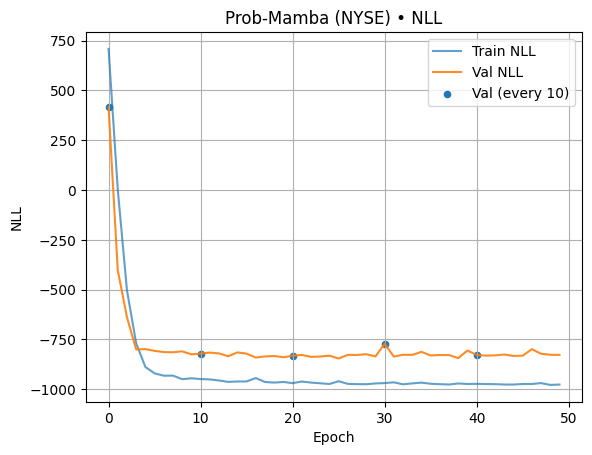

NameError: name 'math' is not defined

In [71]:
# Prob_mamba on NYSE data
# Build loaders
trainL, valL, testL, input_dim, L = build_seq2seq_loaders(
    prefix="cleaned_NYSE", key_in_all="NYSE",
    all_processed_data=all_processed_data, batch_size=64
)

# Build 100k model with n_state fixed to 16
prob_mamba = build_prob_mamba_budget_fixed_n(
    input_dim=input_dim, target=100_000, n_state=16,
    n_layers=1, d_state=16, d_conv=4, expand=2,
    d_feat_min=32, d_feat_max=192, d_feat_step=8, tol_frac=0.03, verbose=True
).to(device)

# Train + record
hist = train_prob_mamba_with_history(prob_mamba, trainL, valL, device=device, epochs=50, lr=1e-3, print_every=10)

# Plot Val NLL vs epoch
plot_nll_history(hist, every=10, title="Prob-Mamba (NYSE) • NLL")

# Evaluate
metrics = eval_prob_rmse_qlike_laststep(prob_mamba, testL, device)
print(f"[Prob-Mamba • NYSE] test NLL: {metrics['nll']:.6f} | last-step RMSE: {metrics['rmse']:.6f} | QLIKE: {metrics['qlike']:.6f}")

In [ ]:
nll = metrics['nll']
nll_str = f"{nll:.6f}" if nll is not None else "N/A"
print(f"[Prob-Mamba • NYSE] last-step RMSE: {metrics['rmse']:.6f} | QLIKE: {metrics['qlike']:.6f}")

[Prob-Mamba • NYSE] last-step RMSE: 0.010154 | QLIKE: -8.191867


[Prob-Mamba n=16] (closest) target≈100,000 | got=105,474 | d_feat=64 | layers=1 | head-only≈68,820
[ep 001] train NLL 799.127507 | val NLL 312.453374
[ep 010] train NLL -941.959472 | val NLL -671.321421
[ep 020] train NLL -966.513649 | val NLL -671.478354
[ep 030] train NLL -974.449728 | val NLL -571.439534
[ep 040] train NLL -965.591040 | val NLL -584.660011
[ep 050] train NLL -969.769019 | val NLL -550.504325


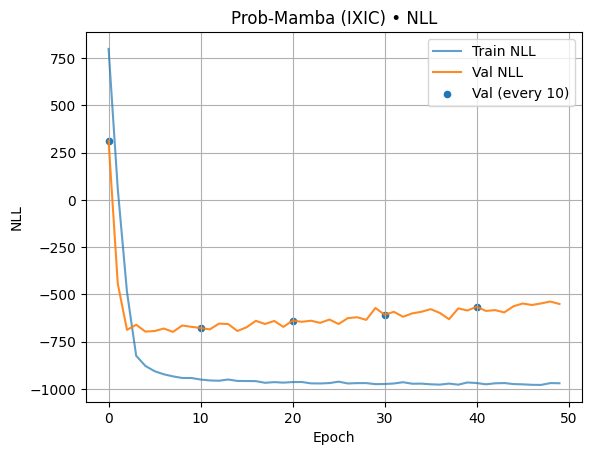

Training wall time: 40.77 min


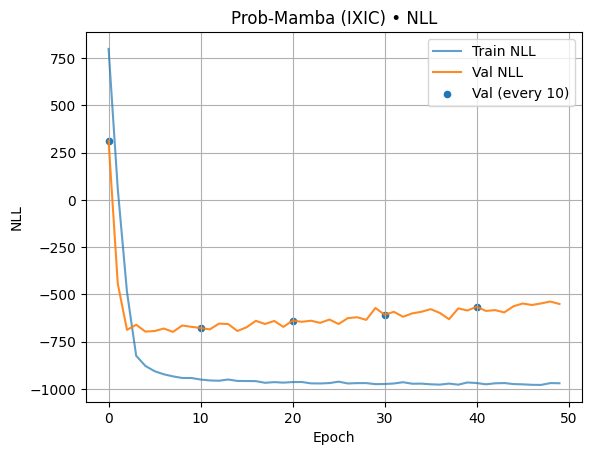

TypeError: unsupported format string passed to NoneType.__format__

In [83]:
# Prob_mamba on Bitcoin data
# Build loaders
trainL, valL, testL, input_dim, L = build_seq2seq_loaders(
    prefix="cleaned_IXIC", key_in_all="IXIC",
    all_processed_data=all_processed_data, batch_size=64
)

# Build 100k model with n_state fixed to 16
prob_mamba = build_prob_mamba_budget_fixed_n(
    input_dim=input_dim, target=100_000, n_state=16,
    n_layers=1, d_state=16, d_conv=4, expand=2,
    d_feat_min=32, d_feat_max=192, d_feat_step=8, tol_frac=0.03, verbose=True
).to(device)

def wall_time(fn, *args, **kwargs):
    t0 = time.perf_counter()
    out = fn(*args, **kwargs)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    dt = time.perf_counter() - t0
    return out, dt

# Train + record
hist, seconds = wall_time(
    train_prob_mamba_with_history,
    prob_mamba, trainL, valL,
    device=device, epochs=50, lr=1e-3
)

plot_nll_history(hist, every=10, title="Prob-Mamba (IXIC) • NLL")
print(f"Training wall time: {seconds/60:.2f} min")

# Plot Val NLL vs epoch
plot_nll_history(hist, every=10, title="Prob-Mamba (IXIC) • NLL")

# Evaluate
metrics = eval_prob_rmse_qlike_laststep(prob_mamba, testL, device)
print(f"[Prob-Mamba • IXIC] test NLL: {metrics['nll']:.6f} | last-step RMSE: {metrics['rmse']:.6f} | QLIKE: {metrics['qlike']:.6f}")

In [84]:
nll = metrics.get('nll')
nll_str = f"{nll:.6f}" if isinstance(nll, (int, float)) else "N/A"
print(f"[Prob-Mamba • IXIC] test NLL: {nll_str} | last-step RMSE: {metrics['rmse']:.6f} | QLIKE: {metrics['qlike']:.6f}")

[Prob-Mamba • IXIC] test NLL: N/A | last-step RMSE: 0.015497 | QLIKE: -6.971491
